# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [1]:
# Import essential modules. Feel free to add whatever you need.
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [2]:
device = 2

In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

        self.avg_pool = nn.AvgPool2d(kernel_size=7)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.avg_pool(x)
        x = self.gelu(x)
        return x


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()

        self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7)
        self.bn = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.layers = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.layers = nn.Sequential(
            DownConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.layers = nn.Sequential(
            UpConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x

In [4]:
# Sanity checks
x = torch.randn(1, 1, 28, 28)
conv = Conv(1, 16)
x = conv(x)
assert x.shape == (1, 16, 28, 28)

down_conv = DownConv(16, 32)
x = down_conv(x)
assert x.shape == (1, 32, 14, 14)

up_conv = UpConv(32, 16)
x = up_conv(x)
assert x.shape == (1, 16, 28, 28)

x = torch.randn(1, 1, 7, 7)
flatten = Flatten()
x = flatten(x)
assert x.shape == (1, 1, 1, 1)

unflatten = Unflatten(1)
x = unflatten(x)
assert x.shape == (1, 1, 7, 7)

conv_block = ConvBlock(1, 16)
x = conv_block(x)
assert x.shape == (1, 16, 7, 7)

down_block = DownBlock(16, 32)
x = down_block(x)
assert x.shape == (1, 32, 4, 4)

up_block = UpBlock(32, 16)
x = up_block(x)
assert x.shape == (1, 16, 8, 8)

## Implementing Unconditional UNet

In [5]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.input_conv = ConvBlock(in_channels, num_hiddens)

        self.down_blocks = nn.ModuleList()
        self.down_blocks.append(DownBlock(num_hiddens, num_hiddens))
        self.down_blocks.append(DownBlock(num_hiddens, num_hiddens * 2))

        self.flatten = Flatten()

        self.unflatten = Unflatten(num_hiddens * 2)

        self.up_blocks = nn.ModuleList()
        self.up_blocks.append(UpBlock(num_hiddens * 4, num_hiddens))
        self.up_blocks.append(UpBlock(num_hiddens * 2, num_hiddens))

        self.out_conv1 = ConvBlock(num_hiddens * 2, num_hiddens)

        self.out_conv2 = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x = self.input_conv(x)
        first_x = x

        down_outputs = []
        for down_block in self.down_blocks:
            x = down_block(x)
            down_outputs.append(x)
        
        x = self.flatten(x)

        x = self.unflatten(x)

        for i, up_block in enumerate(self.up_blocks):
            x = torch.cat([x, down_outputs[-i - 1]], dim=1)
            x = up_block(x)
        
        x = torch.cat([x, first_x], dim=1)
        x = self.out_conv1(x)

        x = self.out_conv2(x)
        return x

In [6]:
unet = UnconditionalUNet(1, 16)

# Sanity check
x = torch.randn(1, 1, 28, 28)
y = unet(x)
assert y.shape == (1, 1, 28, 28)

## Training

In [7]:
class NoisyMNIST(torch.utils.data.Dataset):
    def __init__(self, noise_level: float = 0.1, train: bool = True):
        dataset = MNIST(root="data", download=True, transform=ToTensor(), train=train)
    
        self.dataset = dataset
        self.noise_level = noise_level
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        x_noisy = x + self.noise_level * torch.randn_like(x)
        return x_noisy, x
    
    def __repr__(self):
        return f"NoisyMNIST(noise_level={self.noise_level})"

In [8]:
dataset0 = NoisyMNIST(noise_level=0.0)
dataset2 = NoisyMNIST(noise_level=0.2)
dataset4 = NoisyMNIST(noise_level=0.4)
dataset5 = NoisyMNIST(noise_level=0.5)
dataset6 = NoisyMNIST(noise_level=0.6)
dataset8 = NoisyMNIST(noise_level=0.8)
dataset10 = NoisyMNIST(noise_level=1.0)

datasets = [dataset0, dataset2, dataset4, dataset5, dataset6, dataset8, dataset10]

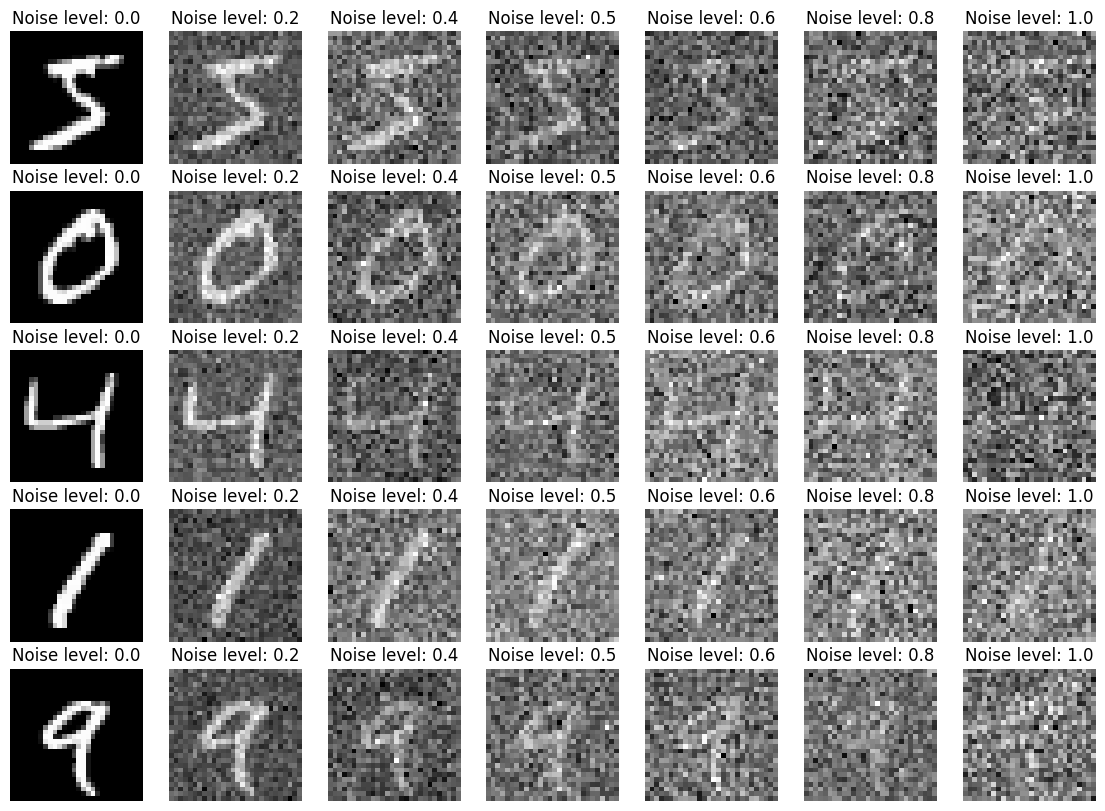

In [9]:
fig, axs = plt.subplots(5, 7, figsize=(14, 10))

for j in range(5):
    for i, dataset in enumerate(datasets):
        x, _ = dataset[j]
        axs[j, i].imshow(x.squeeze(), cmap="gray")
        axs[j, i].axis("off")
        axs[j, i].set_title(f"Noise level: {dataset.noise_level}")

In [10]:
train_dataloader = DataLoader(dataset5, batch_size=256, shuffle=True)

test_dataset = NoisyMNIST(noise_level=0.5, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
unet = UnconditionalUNet(1, 128).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
loss = nn.MSELoss()

In [12]:
def train_step(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred = unet(x)
    l = loss(y_pred, y)
    l.backward()
    optimizer.step()
    return l

In [13]:
def plot_pred(test_x, test_y):
    test_y_pred = unet(test_x)

    fig, axs = plt.subplots(3, 3, figsize=(6, 6))

    for i in range(3):
        axs[i, 0].imshow(test_y[i].cpu().squeeze(), cmap="gray")
        axs[i, 0].axis("off")
        axs[i, 0].set_title("Ground Truth")

        axs[i, 1].imshow(test_x[i].cpu().squeeze(), cmap="gray")
        axs[i, 1].axis("off")
        axs[i, 1].set_title("Input (sigma = 0.5)")

        axs[i, 2].imshow(test_y_pred[i].detach().cpu().squeeze(), cmap="gray")
        axs[i, 2].axis("off")
        axs[i, 2].set_title("Prediction")

    plt.show()

In [87]:
test_x, test_y = next(iter(test_dataloader))
test_x = test_x.to(device)
test_y = test_y.to(device)

In [86]:
# First epoch
train_losses = []
epoch = 1
train_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch}")
for x, y in train_tqdm:
    l = train_step(x, y)
    train_losses.append(l.item())
    train_tqdm.set_postfix({"loss": l.item()})

Epoch 1: 100%|██████████| 235/235 [00:23<00:00, 10.20it/s, loss=0.0121]


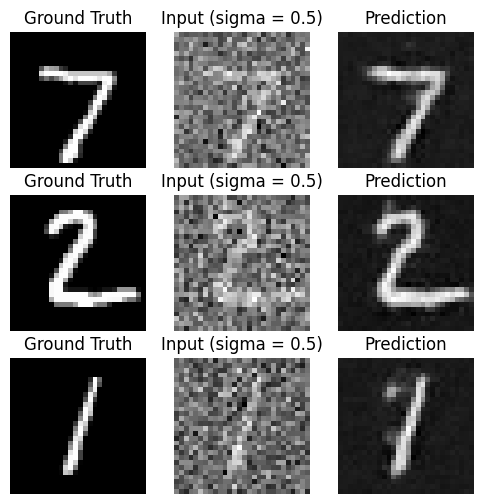

In [93]:
plot_pred(test_x, test_y)

In [94]:
for epoch in range(1, 5):
    train_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch}")
    for x, y in train_tqdm:
        l = train_step(x, y)
        train_losses.append(l.item())
        train_tqdm.set_postfix(loss=l.item())
    print(f"Epoch {epoch}, loss: {l.item()}")

Epoch 1: 100%|██████████| 235/235 [00:22<00:00, 10.24it/s, loss=0.00964]


Epoch 1, loss: 0.0096419183537364


Epoch 2: 100%|██████████| 235/235 [00:22<00:00, 10.35it/s, loss=0.00891]


Epoch 2, loss: 0.008911827579140663


Epoch 3: 100%|██████████| 235/235 [00:23<00:00, 10.07it/s, loss=0.00815]


Epoch 3, loss: 0.0081504350528121


Epoch 4: 100%|██████████| 235/235 [00:22<00:00, 10.26it/s, loss=0.00816]

Epoch 4, loss: 0.008155690506100655


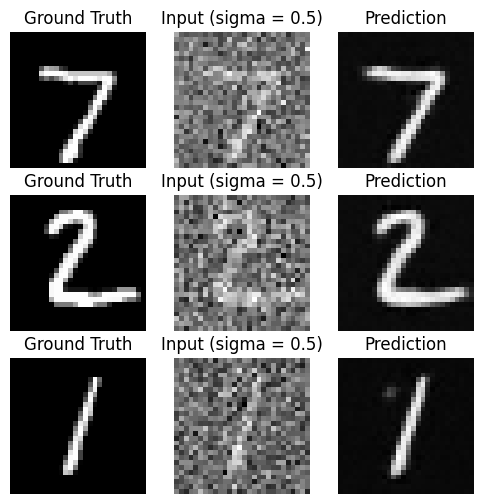

In [95]:
plot_pred(test_x, test_y)

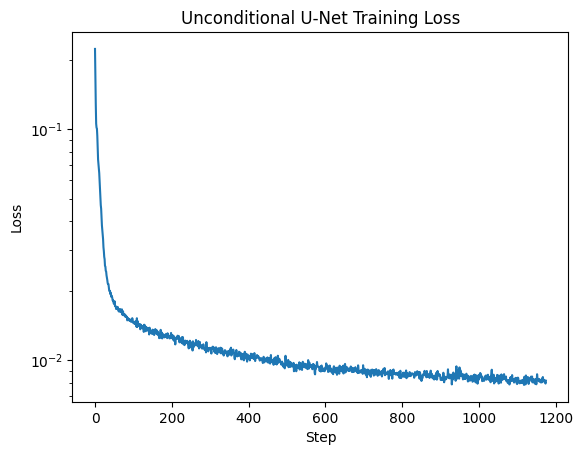

In [98]:
# Plot the training loss

plt.plot(train_losses)
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Unconditional U-Net Training Loss")
plt.show()

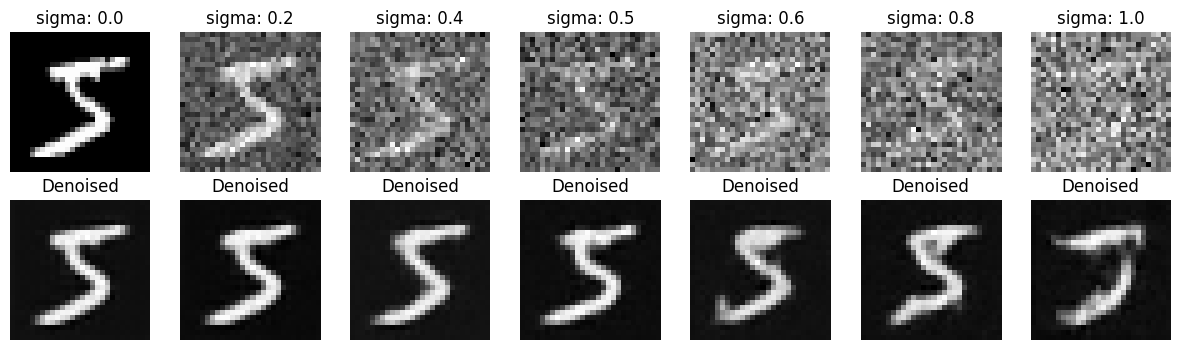

In [107]:
# Out of distribution

fig, axs = plt.subplots(2, 7, figsize=(15, 4))

for i, dataset in enumerate(datasets):
    x, _ = dataset[0]
    axs[0, i].imshow(x.squeeze(), cmap="gray")
    axs[0, i].axis("off")
    axs[0, i].set_title(f"sigma: {dataset.noise_level}")

    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        y = unet(x)
    axs[1, i].imshow(y.cpu().squeeze(), cmap="gray")
    axs[1, i].axis("off")
    axs[1, i].set_title("Denoised")

# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [14]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        
        self.input_conv = ConvBlock(in_channels, num_hiddens)

        self.down_blocks = nn.ModuleList()
        self.down_blocks.append(DownBlock(num_hiddens, num_hiddens))
        self.down_blocks.append(DownBlock(num_hiddens, num_hiddens * 2))

        self.flatten = Flatten()

        self.unflatten = Unflatten(num_hiddens * 2)

        self.up_blocks = nn.ModuleList()
        self.up_blocks.append(UpBlock(num_hiddens * 4, num_hiddens))
        self.up_blocks.append(UpBlock(num_hiddens * 2, num_hiddens))

        self.out_conv1 = ConvBlock(num_hiddens * 2, num_hiddens)

        self.out_conv2 = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)

        self.fc_lower = FCBlock(1, num_hiddens * 2)
        self.fc_higher = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        t_low = self.fc_lower(t)
        t_high = self.fc_higher(t)
        t_low = t_low.unsqueeze(-1).unsqueeze(-1)
        t_high = t_high.unsqueeze(-1).unsqueeze(-1)

        x = self.input_conv(x)
        first_x = x

        down_outputs = []
        for down_block in self.down_blocks:
            x = down_block(x)
            down_outputs.append(x)
        
        x = self.flatten(x)

        x = self.unflatten(x) + t_low

        for i, up_block in enumerate(self.up_blocks):
            x = torch.cat([x, down_outputs[-i - 1]], dim=1)
            x = up_block(x)
            if i == 0:
                x += t_high
        
        x = torch.cat([x, first_x], dim=1)
        x = self.out_conv1(x)

        x = self.out_conv2(x)
        return x

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [15]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    return {
        "d_betas": betas,
        "d_alphas": alphas,
        "d_alpha_bars": alpha_bars,
    }

In [23]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
    display=False
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()

    if display:
        plt.imshow(x_0[0].squeeze().detach().cpu(), cmap="gray")
        plt.show()

    alpha_bars = ddpm_schedule["d_alpha_bars"]

    t = torch.randint(0, num_ts, (x_0.shape[0],))

    alpha_bars_t = alpha_bars[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(x_0.device)
    t = (t / (num_ts)).unsqueeze(-1).to(x_0.device)
    
    epsilon = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bars_t) * x_0 + torch.sqrt(1.0 - alpha_bars_t) * epsilon
    if display:
        plt.imshow(x_t[0].squeeze().detach().cpu(), cmap="gray")
        plt.show()
    epsilon_hat = unet(x_t, t)
    loss = nn.MSELoss()(epsilon, epsilon_hat)

    return loss

In [59]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()

    betas = ddpm_schedule["d_betas"]
    alphas = ddpm_schedule["d_alphas"]
    alpha_bars = ddpm_schedule["d_alpha_bars"]

    x_t = torch.randn(1, 1, img_wh[0], img_wh[1])
    for t in range(num_ts - 1, 0, -1):
        z = torch.randn(1, 1, img_wh[0], img_wh[1]) # if t > 1 else torch.zeros(1, 1, img_wh[0], img_wh[1])

        input_t = torch.tensor(t / (num_ts)).unsqueeze(-1).unsqueeze(-1).to(x_t.device)

        unet = unet.to(x_t.device)

        x_0_hat = (1 / torch.sqrt(alpha_bars[t])) * (x_t - torch.sqrt(1.0 - alpha_bars[t]) * unet(x_t, input_t))
        x_t = (torch.sqrt(alpha_bars[t - 1]) * betas[t])/(1 - alpha_bars[t]) * x_0_hat + (torch.sqrt(alphas[t]) * (1 - alpha_bars[t - 1]))/(1 - alpha_bars[t]) * x_t + torch.sqrt(betas[t]) * z

    return x_t

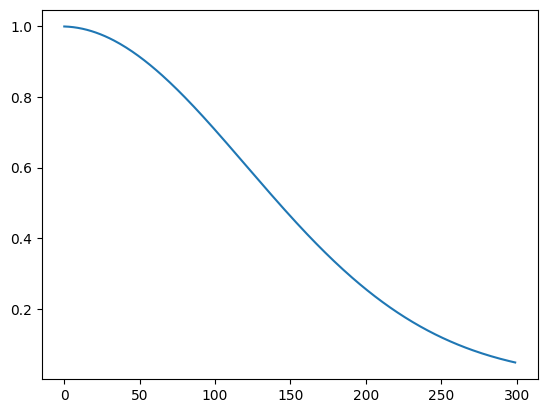

In [25]:
schedule = ddpm_schedule(1e-4, 0.02, 300)
plt.plot(schedule["d_alpha_bars"])

In [26]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

In [69]:
tc_unet = TimeConditionalUNet(1, 1, 64).to(device)
tc_ddpm = DDPM(tc_unet).to(device)

dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

n_epochs = 20
optimizer = torch.optim.Adam(tc_ddpm.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [55]:
def train_step(x: torch.Tensor) -> torch.Tensor:
    x = x.to(device).float()
    optimizer.zero_grad()
    l = tc_ddpm(x)
    l.backward()
    optimizer.step()
    return l

In [70]:
train_losses = []
tc_ddpm.train()
tc_ddpm = tc_ddpm.to(device)
tc_unet = tc_unet.to(device)
for epoch in range(5):
    train_tqdm = tqdm(dataloader, desc=f"Epoch {epoch}")
    for x, _ in train_tqdm:
        x = x.to(device)
        l = train_step(x)
        train_losses.append(l.item())
        train_tqdm.set_postfix(loss=l.item())
    scheduler.step()

Epoch 4: 100%|██████████| 235/235 [00:12<00:00, 18.40it/s, loss=0.039] 


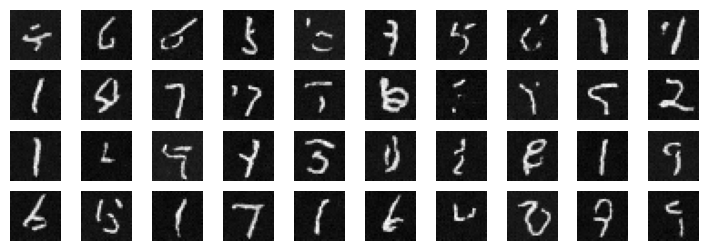

In [64]:
def plot_pred():
    fig, axs = plt.subplots(4, 10, figsize=(9, 3))

    for i in range(4):
        for j in range(10):
            x = tc_ddpm.sample((28, 28))
            axs[i, j].imshow(x.squeeze().detach().cpu(), cmap="gray")
            axs[i, j].axis("off")

plot_pred()

In [71]:
tc_ddpm.train()
tc_ddpm = tc_ddpm.to(device)
tc_unet = tc_unet.to(device)
for epoch in range(15):
    train_tqdm = tqdm(dataloader, desc=f"Epoch {epoch}")
    for x, _ in train_tqdm:
        x = x.to(device)
        l = train_step(x)
        train_losses.append(l.item())
        train_tqdm.set_postfix(loss=l.item())
    scheduler.step()

Epoch 14: 100%|██████████| 235/235 [00:12<00:00, 19.00it/s, loss=0.0283]


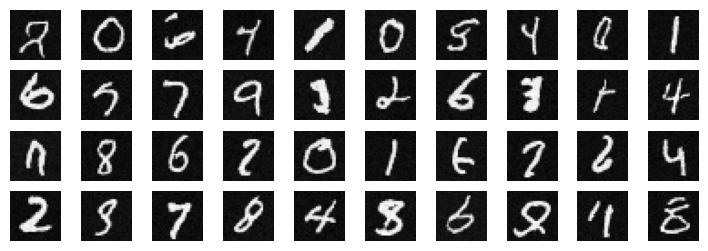

In [72]:
plot_pred()

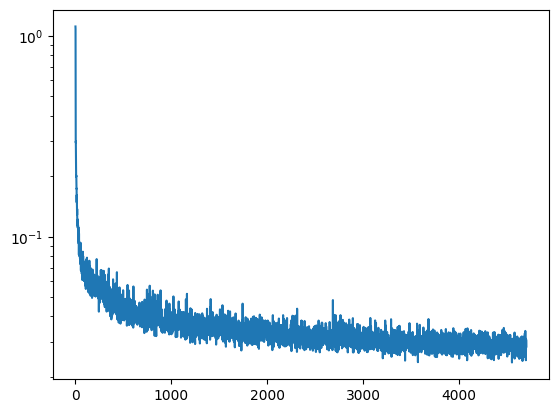

In [73]:
plt.plot(train_losses)
plt.yscale("log")

### Implementing class-conditioned UNet

In [137]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.input_conv = ConvBlock(in_channels, num_hiddens)

        self.down_blocks = nn.ModuleList()
        self.down_blocks.append(DownBlock(num_hiddens, num_hiddens))
        self.down_blocks.append(DownBlock(num_hiddens, num_hiddens * 2))

        self.flatten = Flatten()

        self.unflatten = Unflatten(num_hiddens * 2)

        self.up_blocks = nn.ModuleList()
        self.up_blocks.append(UpBlock(num_hiddens * 4, num_hiddens))
        self.up_blocks.append(UpBlock(num_hiddens * 2, num_hiddens))

        self.out_conv1 = ConvBlock(num_hiddens * 2, num_hiddens)

        self.out_conv2 = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)

        self.fc_lower = FCBlock(1, num_hiddens * 2)
        self.fc_higher = FCBlock(1, num_hiddens)

        self.fc_c_lower = FCBlock(num_classes, num_hiddens * 2)
        self.fc_c_higher = FCBlock(num_classes, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        t_low = self.fc_lower(t)
        t_high = self.fc_higher(t)
        t_low = t_low.unsqueeze(-1).unsqueeze(-1)
        t_high = t_high.unsqueeze(-1).unsqueeze(-1)

        c = mask * c

        c_low = self.fc_c_lower(c)
        c_high = self.fc_c_higher(c)

        c_low = c_low.unsqueeze(-1).unsqueeze(-1)
        c_high = c_high.unsqueeze(-1).unsqueeze(-1)

        x = self.input_conv(x)
        first_x = x

        down_outputs = []
        for down_block in self.down_blocks:
            x = down_block(x)
            down_outputs.append(x)
        
        x = self.flatten(x)

        x = c_low * self.unflatten(x) + t_low

        for i, up_block in enumerate(self.up_blocks):
            x = torch.cat([x, down_outputs[-i - 1]], dim=1)
            x = up_block(x)
            if i == 0:
                x = x * c_high + t_high
        
        x = torch.cat([x, first_x], dim=1)
        x = self.out_conv1(x)

        x = self.out_conv2(x)
        return x

In [138]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
    display: bool = False
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()

    if display:
        plt.imshow(x_0[0].squeeze().detach().cpu(), cmap="gray")
        plt.show()

    alpha_bars = ddpm_schedule["d_alpha_bars"]

    t = torch.randint(0, num_ts, (x_0.shape[0],))

    alpha_bars_t = alpha_bars[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(x_0.device)
    t = (t / (num_ts)).unsqueeze(-1).to(x_0.device)
    c = c.to(x_0.device)

    mask = torch.rand(x_0.shape[0], 1) < p_uncond
    mask = mask.to(x_0.device)
    
    epsilon = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bars_t) * x_0 + torch.sqrt(1.0 - alpha_bars_t) * epsilon
    if display:
        plt.imshow(x_t[0].squeeze().detach().cpu(), cmap="gray")
        plt.show()
    epsilon_hat = unet(x_t, c, t, mask)
    loss = nn.MSELoss()(epsilon, epsilon_hat)

    return loss

In [139]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    betas = ddpm_schedule["d_betas"]
    alphas = ddpm_schedule["d_alphas"]
    alpha_bars = ddpm_schedule["d_alpha_bars"]

    x_t = torch.randn(1, 1, img_wh[0], img_wh[1]).to(device)
    for t in range(num_ts - 1, 0, -1):
        z = torch.randn(1, 1, img_wh[0], img_wh[1])

        input_t = torch.tensor(t / (num_ts)).unsqueeze(-1).unsqueeze(-1).to(x_t.device)

        epsilon_u = unet(x_t, c, input_t, torch.zeros(1,).to(device))
        epsilon_c = unet(x_t, c, input_t, torch.ones(1,).to(device))
        epsilon = epsilon_u + guidance_scale * (epsilon_c - epsilon_u)

        x_0_hat = (1 / torch.sqrt(alpha_bars[t])) * (x_t - torch.sqrt(1.0 - alpha_bars[t]) * epsilon)
        x_0_hat = x_0_hat.to(device)
        z = z.to(device)
        x_t = (torch.sqrt(alpha_bars[t - 1]) * betas[t])/(1 - alpha_bars[t]) * x_0_hat + (torch.sqrt(alphas[t]) * (1 - alpha_bars[t - 1]))/(1 - alpha_bars[t]) * x_t + torch.sqrt(betas[t]) * z

    return x_t

In [140]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

In [144]:
cc_ddpm = DDPM(ClassConditionalUNet(1, 10, 64)).to(device)

dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

n_epochs = 20
optimizer = torch.optim.Adam(cc_ddpm.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [145]:
def train_step(x: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    x = x.to(device).float()
    label = label.to(device).float()
    optimizer.zero_grad()
    l = cc_ddpm(x, label)
    l.backward()
    optimizer.step()
    return l

In [147]:
train_losses = []
cc_ddpm.train()
cc_ddpm = cc_ddpm.to(device)
for epoch in range(5):
    train_tqdm = tqdm(dataloader, desc=f"Epoch {epoch}")
    for x, c in train_tqdm:
        x = x.to(device)
        c = torch.eye(10)[c].float().to(device)
        l = train_step(x, c)
        train_losses.append(l.item())
        train_tqdm.set_postfix(loss=l.item())
    scheduler.step()

Epoch 4: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s, loss=0.0268]


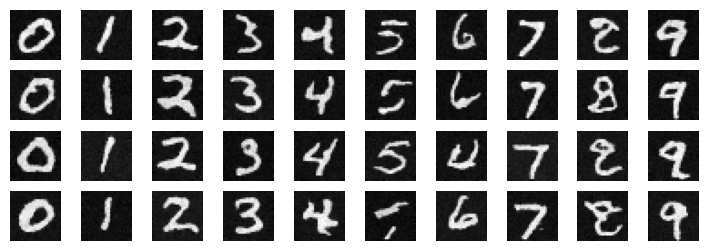

In [164]:
@torch.no_grad()
def plot_pred_cc():
    fig, axs = plt.subplots(4, 10, figsize=(9, 3))

    for i in range(4):
        for j in range(10):
            c = torch.eye(10)[j].float().to(device)
            x = cc_ddpm.sample(c, (28, 28))
            axs[i, j].imshow(x.squeeze().detach().cpu(), cmap="gray")
            axs[i, j].axis("off")

plot_pred_cc()

In [165]:
cc_ddpm.train()
cc_ddpm = cc_ddpm.to(device)
for epoch in range(15):
    train_tqdm = tqdm(dataloader, desc=f"Epoch {epoch}")
    for x, c in train_tqdm:
        x = x.to(device)
        c = torch.eye(10)[c].float().to(device)
        l = train_step(x, c)
        train_losses.append(l.item())
        train_tqdm.set_postfix(loss=l.item())
    scheduler.step()

Epoch 14: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s, loss=0.0252]


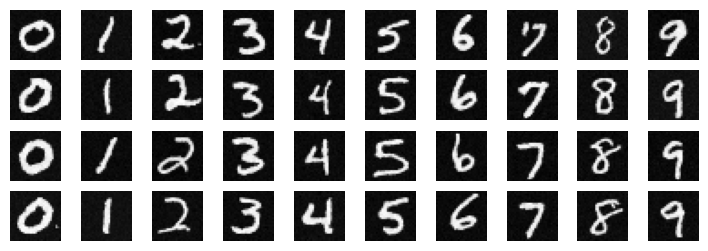

In [166]:
plot_pred_cc()

Text(0, 0.5, 'Loss')

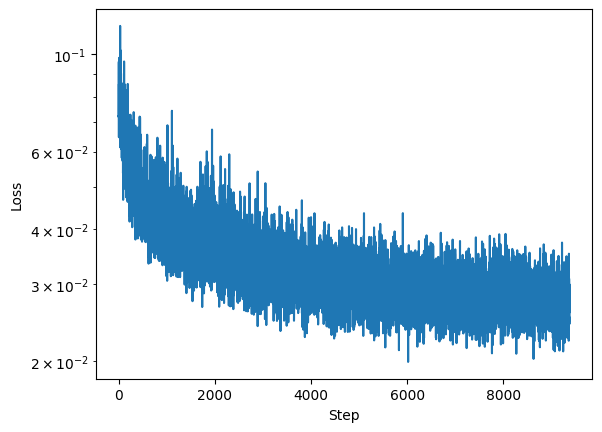

In [167]:
plt.plot(train_losses)
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Loss")